# 1 Introduction

__From Kaggle's website__: 

*"Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.*

*In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers."*

This noteboook dives into the EDA and modeling for the Porto Seguro Kaggle competition in the Python environment. We will use the Pandas and associated libraries for most of the data manipulation and Scikit-learn for the modeling. In this notebook, we will visualize the different features, see how they relate to the target variable, explore multi-parameter interactions, and perform any feature engineering.

The aim of the competition is to predict the probability that a driver will make an insurance claim, with the purpose of providing a fairer insurance cost based on an individual's driving habits.

For this competition, training and test data sets are provided on the Kaggle website in the form of csv files, `../input/train.csv` and `../input/test.csv`, respectively. Each row corresponds to a specific policy holder and columns describe their features. The target variable is labeled *target* and indicates whether a policy holder made an insurance claim the past year. 



# 2 Preperations

### 2.1 Import Libraries

We will import libraries for data wrangling, visualization and analysis.

In [1]:
# data wrangling 
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# analysis
from scipy.stats import skewtest, boxcox
from sklearn.base import TransformerMixin, BaseEstimator

# helper
!pip install tqdm --quiet
from tqdm import tqdm

### 2.2 Helper Functions

Any helper functions used from other sources will be defined here.

### 2.3 Load Data

We will use pandas' `read_csv()` function to import the data into DataFrames. We are told in the Kaggle instructions that the original dataset denotes NaN values by "-1" or "-1.0", so we will include those instructions in the `read_csv()`.

In [2]:
# raw data
train = pd.read_csv('./train.csv', na_values=["-1", "-1.0"])
test = pd.read_csv('./test.csv', na_values=["-1", "-1.0"])
sample_submission = pd.read_csv('./sample_submission.csv')

# 3 Overview: File structure and content

We will explore the data sets using pandas `info()`, `head()`, and `describe()`. 

### 3.1 Train

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.2 Test

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892509 non-null float64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892671 non-null float64
ps_ind_05_cat     884106 non-null float64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         731132 non-null float

In [7]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [8]:
test.describe()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,8.928160e+05,892816.000000,892509.000000,892816.000000,892671.000000,884106.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,1.359424,4.413734,0.417592,0.422005,0.393246,0.257191,0.163659,0.185905,...,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,4.296830e+05,1.986503,0.661671,2.700149,0.493162,1.354464,0.488471,0.437086,0.369966,0.389030,...,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.116308e+06,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488026e+06,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,20.000000,11.000000,15.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.3 Missing Values

In [9]:
print("The training data has {} missing values.".format(train.isnull().sum().sum()))

The training data has 846458 missing values.


In [10]:
print("The test data has {} missing values.".format(test.isnull().sum().sum()))

The test data has 1270295 missing values.


There is an order of a million missing values from the training and test datasets. This will significantly affect our ability to create accurate models if they are not handled.

### 3.4 Reformat features

We will reformat the categorical columns to categorical-type and the binary values into logical. The target will be a categorical-type.

In [11]:
# list of categorical columns
cat_cols = [col for col in train.columns if col.endswith('_bin') or col.endswith('_cat')]

# apply function accross categorical cols
train[cat_cols] = train[cat_cols].apply(pd.Categorical)
test[cat_cols] = test[cat_cols].apply(pd.Categorical)

### 3.5 Combining DataFrames

We will combine the train and test set for the analysis

In [12]:
combine = pd.concat([train, test], axis=0)

# 4 Individual Feature Visualization

In this section, we will visualize the distributions of each of the variables as it relates to the target. Although at first these plots might not tell us much, it is important to have as a reference later on: when an interesting insight related to a feature emerges, it is useful to refer back to the distribution of that feature.

### 4.1 Binary Features

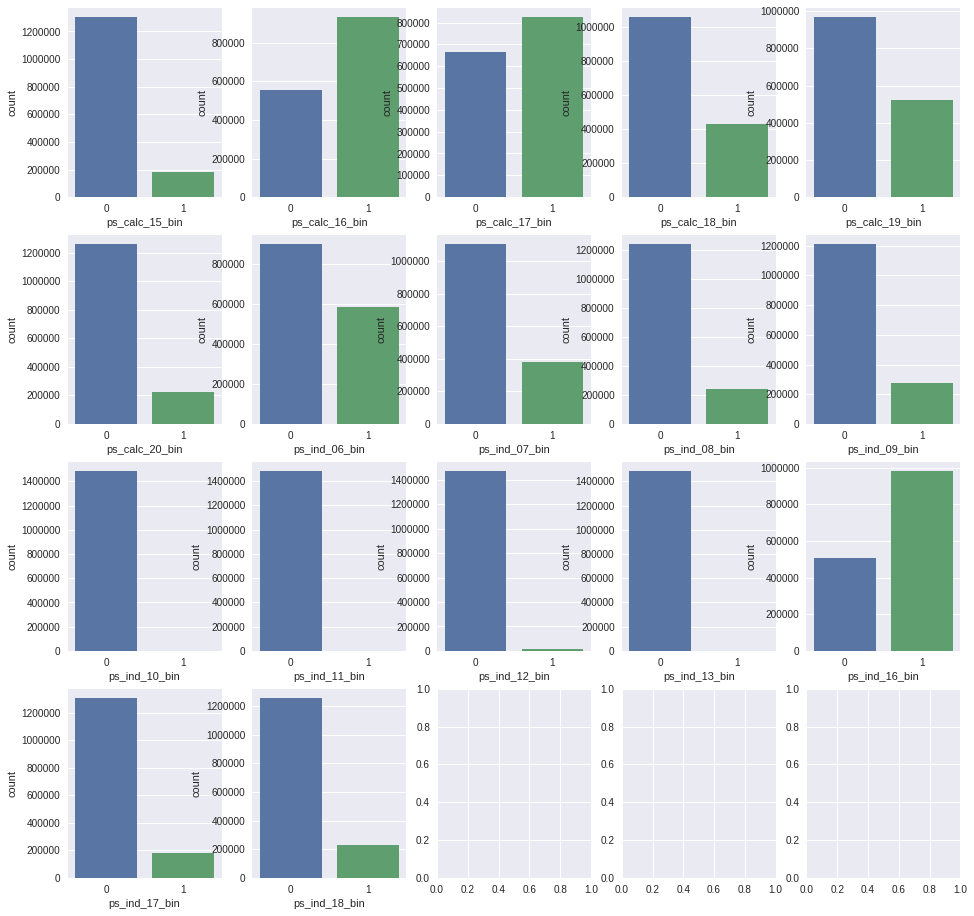

In [13]:
bin_cols = [col for col in combine.columns if col.endswith('_bin')]
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(16,16))

for i, col in enumerate(bin_cols):
    sns.countplot(x = col, data=combine, ax=axs.ravel()[i])

### 4.2 Categorical Features

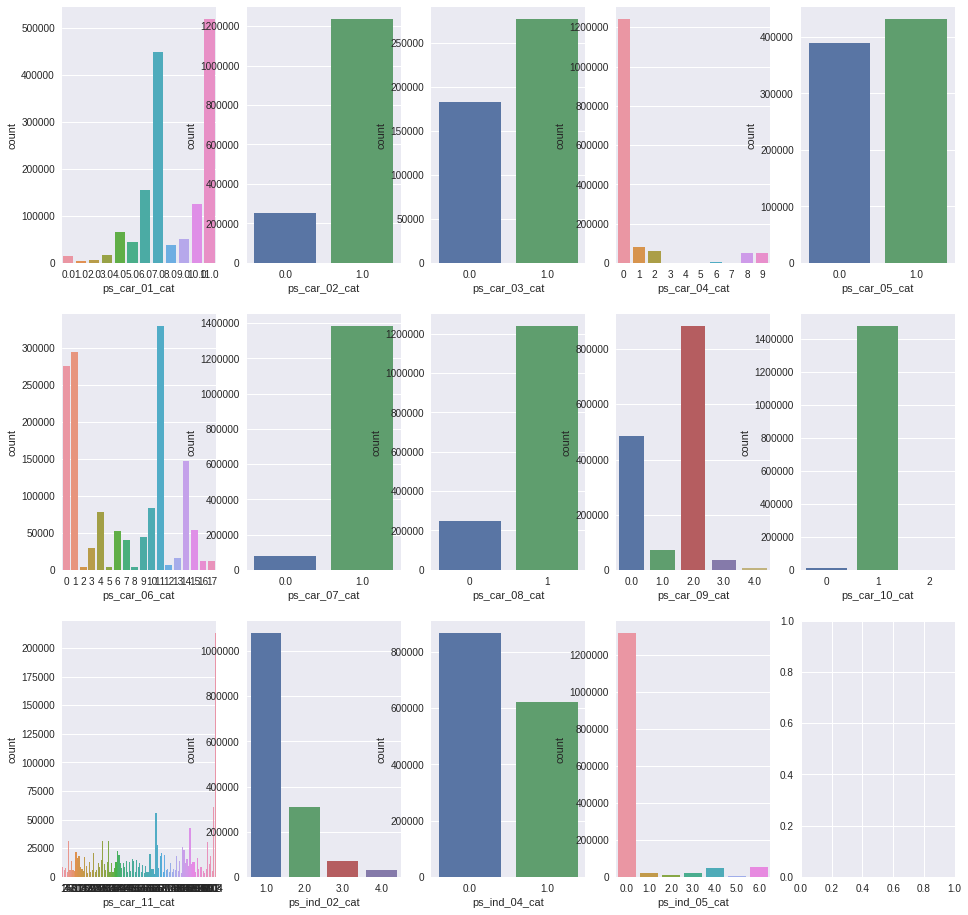

In [14]:
cat_cols = [col for col in combine.columns if col.endswith('_cat')]
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(16,16))

for i, col in enumerate(cat_cols):
    sns.countplot(x = col, data=combine, ax=axs.ravel()[i])

### 4.3 Integer Features

In [15]:
combine.drop(['id'],axis=1, inplace=True)

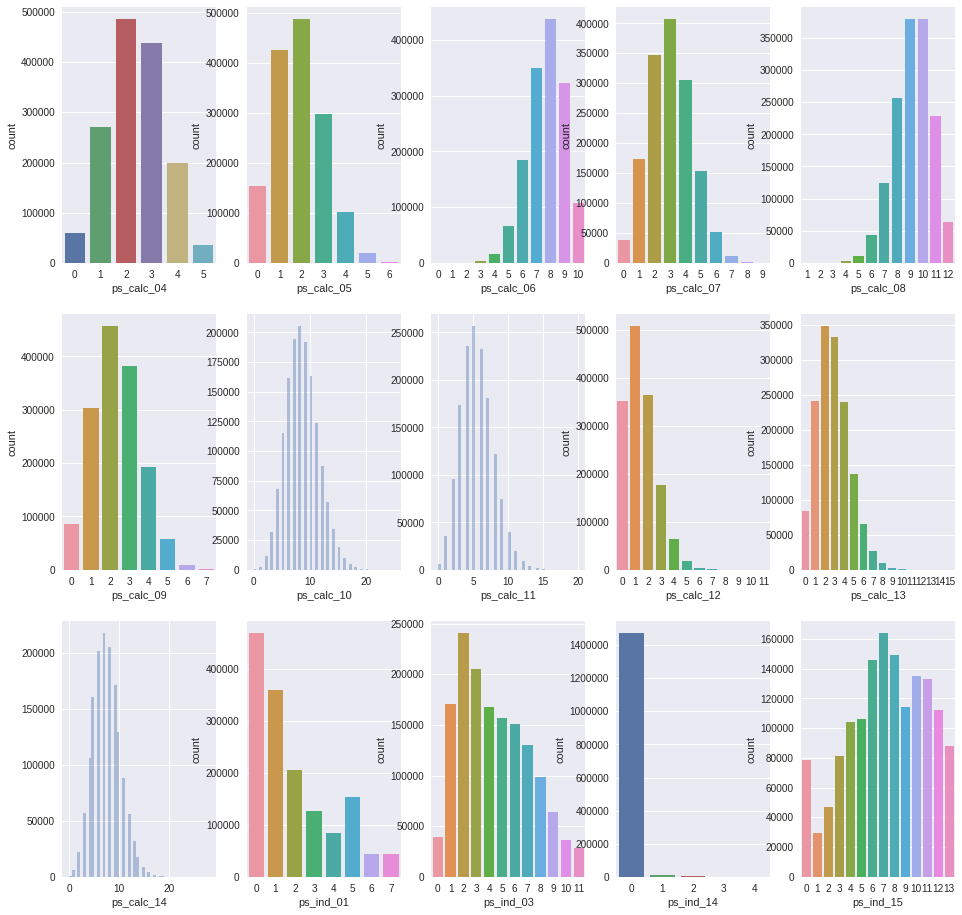

In [16]:
int_cols = [col for col in combine.columns if combine[col].dtype == 'int64']
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(16,16))

for i, col in enumerate(int_cols):
    if 'calc_10' in col or 'calc_11' in col or 'calc_14' in col:
        sns.distplot(a = combine[col], kde = False, ax = axs.ravel()[i])
    else:
        sns.countplot(x = col, data=combine, ax=axs.ravel()[i])

### 4.4 Float Features

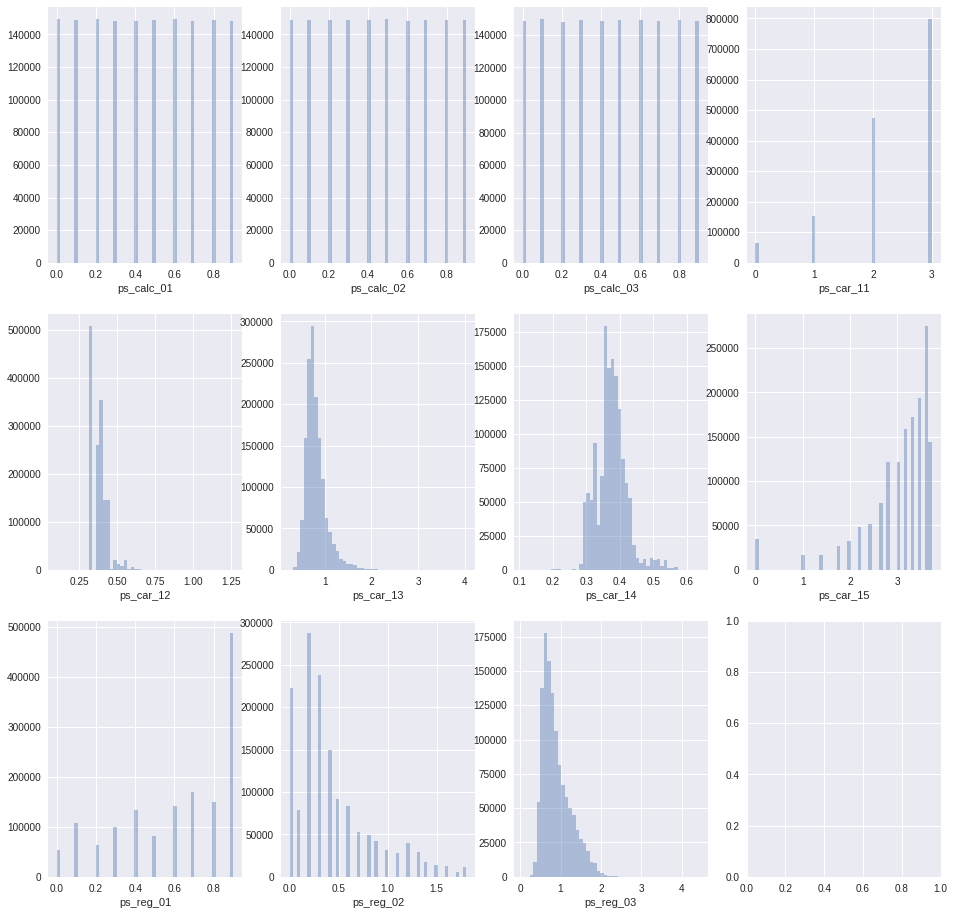

In [17]:
float_cols = [col for col in combine.columns if combine[col].dtype == 'float64']
float_cols.remove('target')
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16))

for i, col in enumerate(float_cols):
    sns.distplot(a = combine[~combine[col].isnull()][col], kde= False,  ax=axs.ravel()[i])

### 4.5 Target

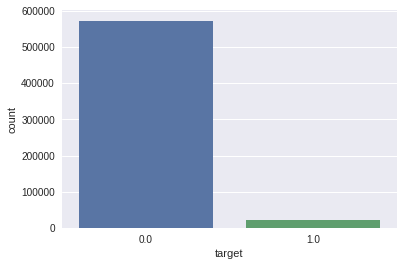

In [18]:
_ = sns.countplot(x = 'target', data = combine)

The majority of cases has no insurance claim.

### 4.6 Missing Values

In [19]:
!pip install missingno --quiet

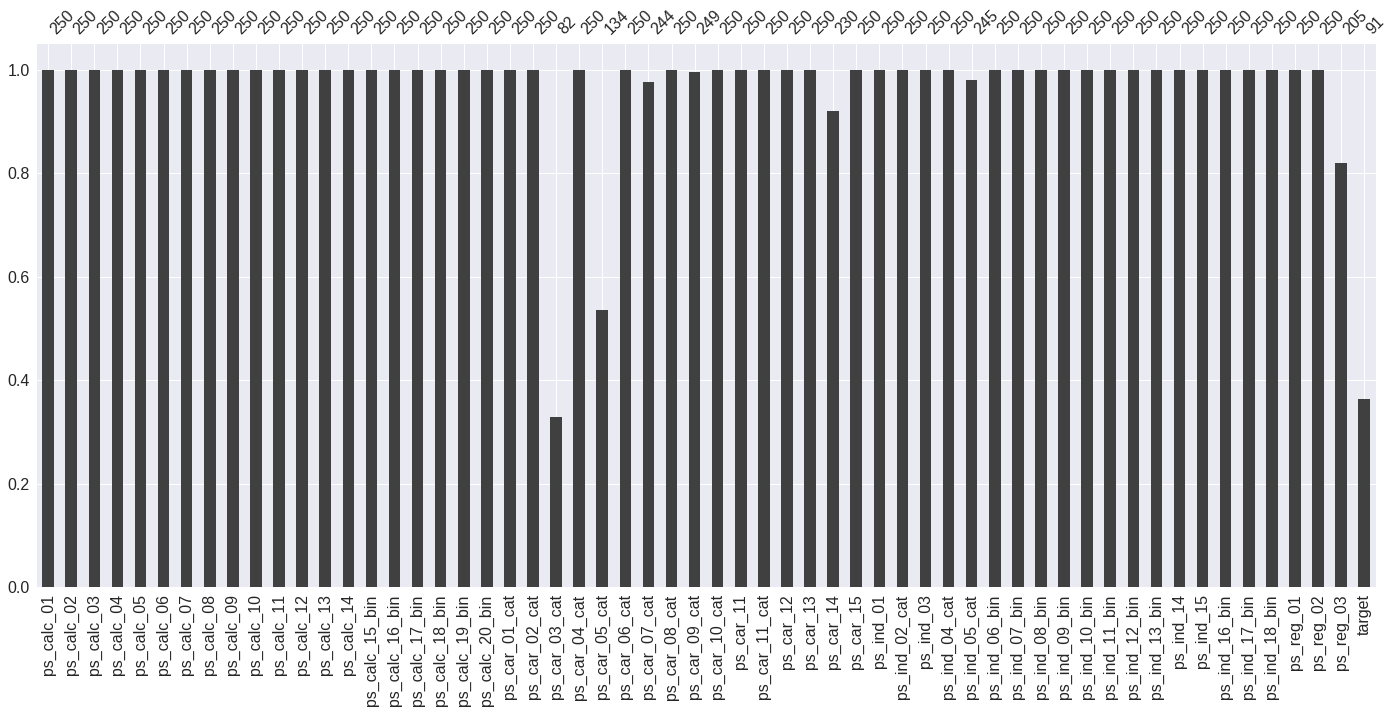

In [20]:
import missingno as msno
msno.bar(combine.sample(250))

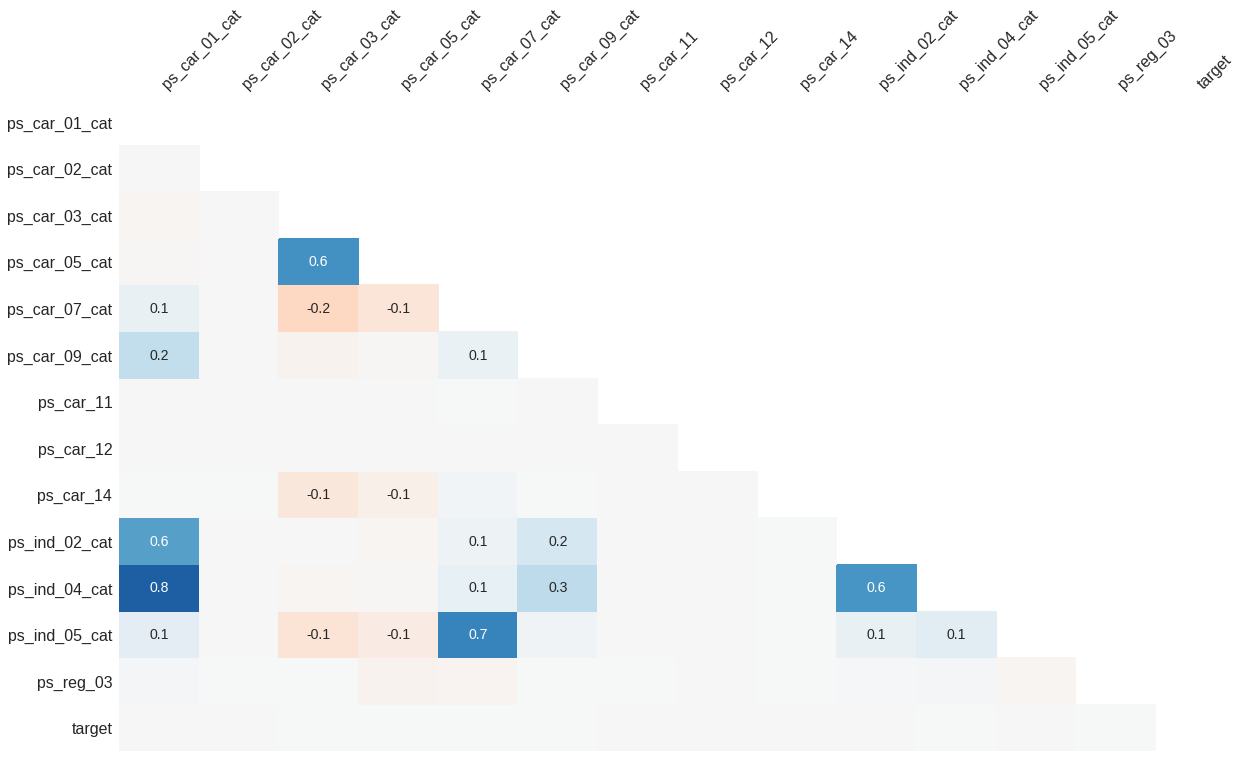

In [21]:
msno.heatmap(combine)

This heatmap measures nullality correlation: how strongly the presence of absence of one variable affects the other. Example, in our data, the presence of variable ps_ind_04_cat strongly indicates the presence of ps_car_01_cat.

# 5 Claim rates for individual features

In this section we visualize the relationship between each individual feature against the target.

### 5.1 Binary Features

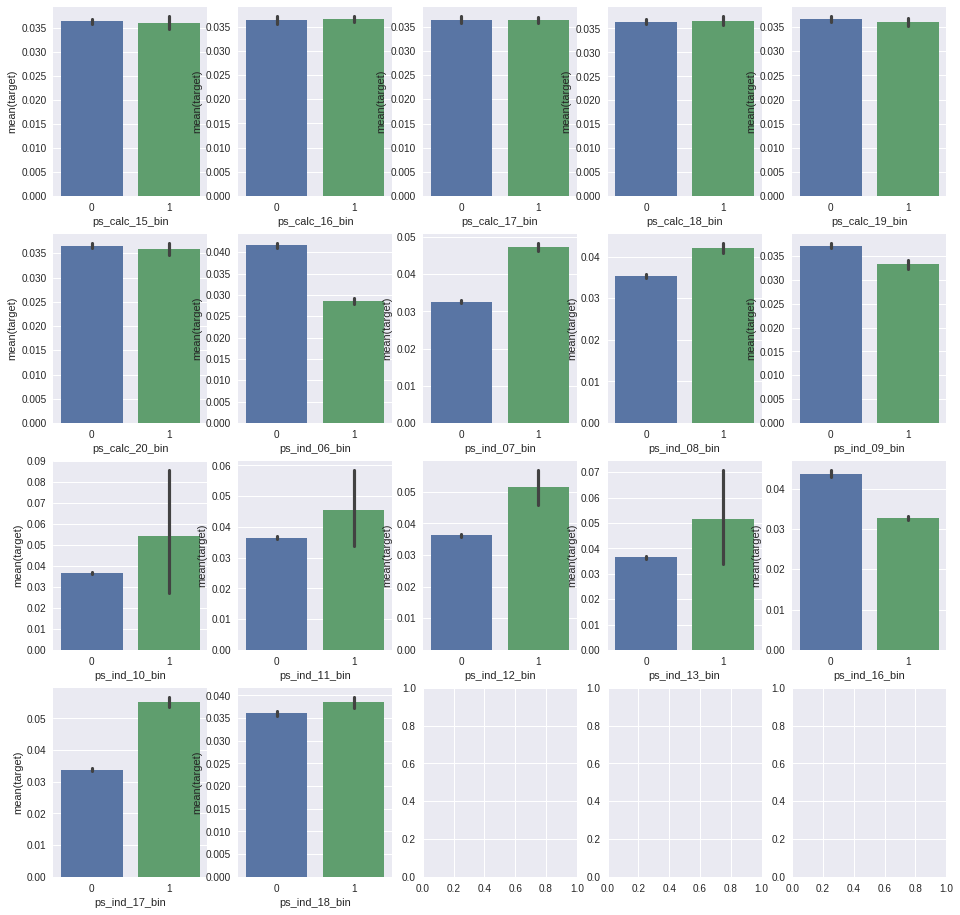

In [22]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(16,16))

for i, col in enumerate(bin_cols):
    sns.barplot(x = col, y = 'target', data = combine, ax=axs.ravel()[i], )

### 5.2 Categorical Features

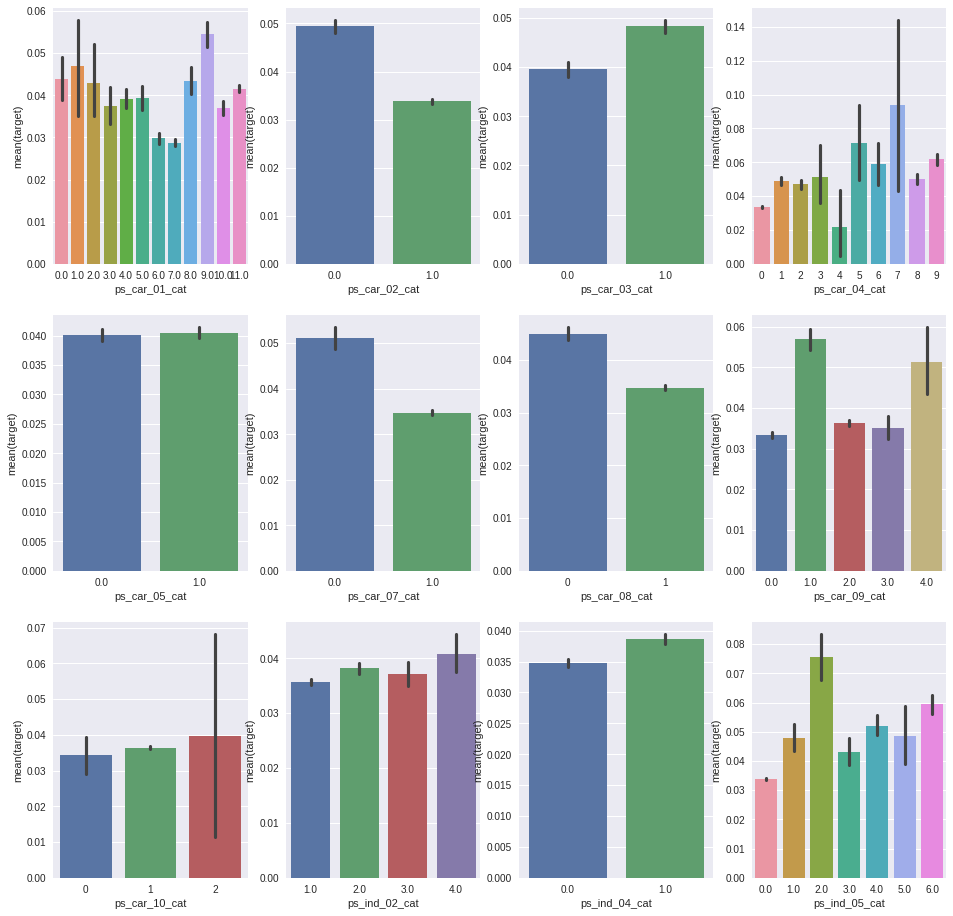

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16))

# handle these variables seperately
cat_cols.remove('ps_car_06_cat')
cat_cols.remove('ps_car_11_cat')

for i, col in enumerate(cat_cols):
    sns.barplot(x = col, y = 'target', data = combine, ax=axs.ravel()[i])

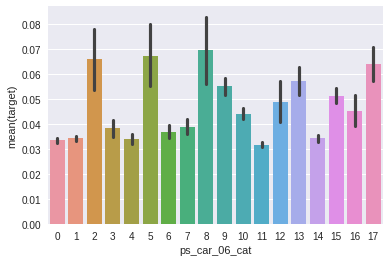

In [24]:
_ = sns.barplot(x = 'ps_car_06_cat', y = 'target', data = combine)

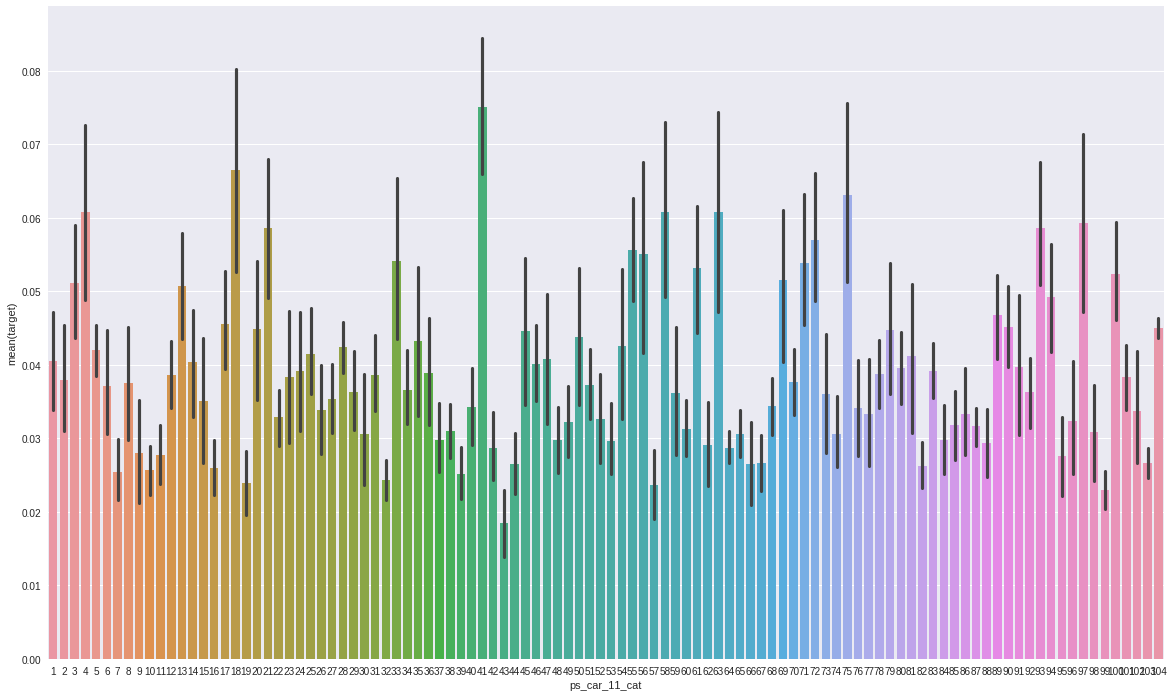

In [25]:
plt.figure(figsize=(20,12))
_ = sns.barplot(x = 'ps_car_11_cat', y = 'target', data = combine)

### 5.3 Integer Features

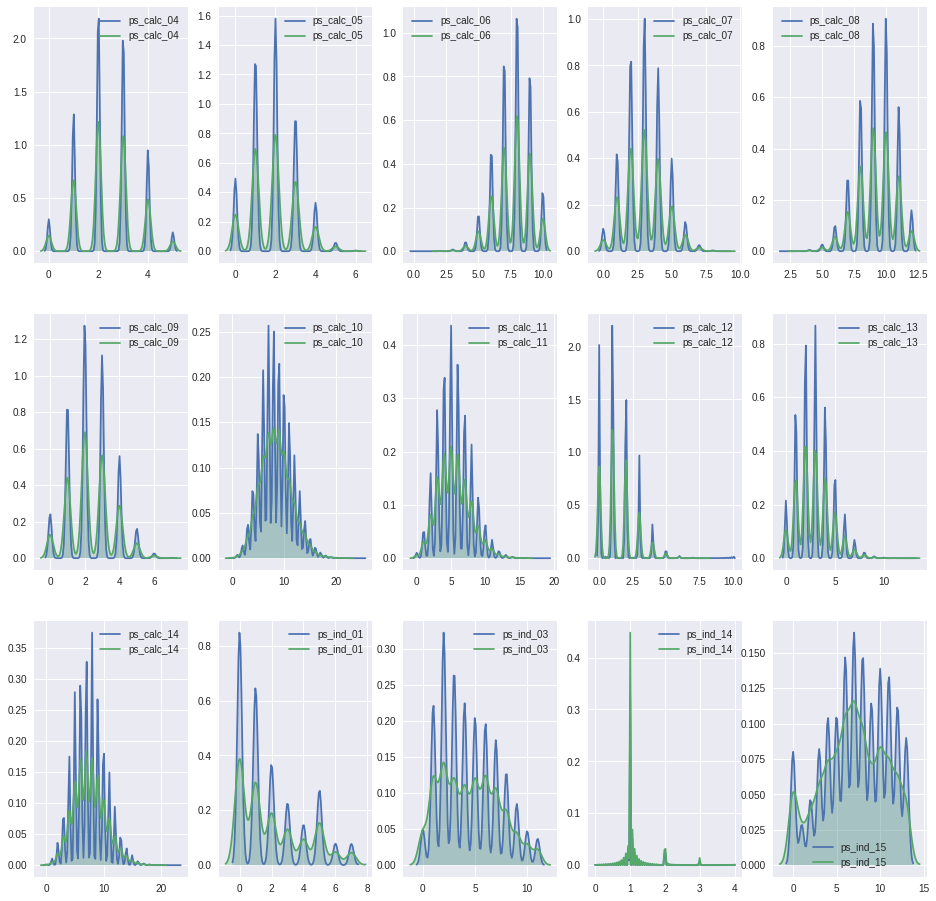

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(16,16))

for i, col in enumerate(int_cols):
    sns.kdeplot(data = combine[combine['target'] == 0][col], ax=axs.ravel()[i], shade=True)
    sns.kdeplot(data = combine[combine['target'] == 1][col], ax=axs.ravel()[i], shade=True)


### 5.4 Float Features

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


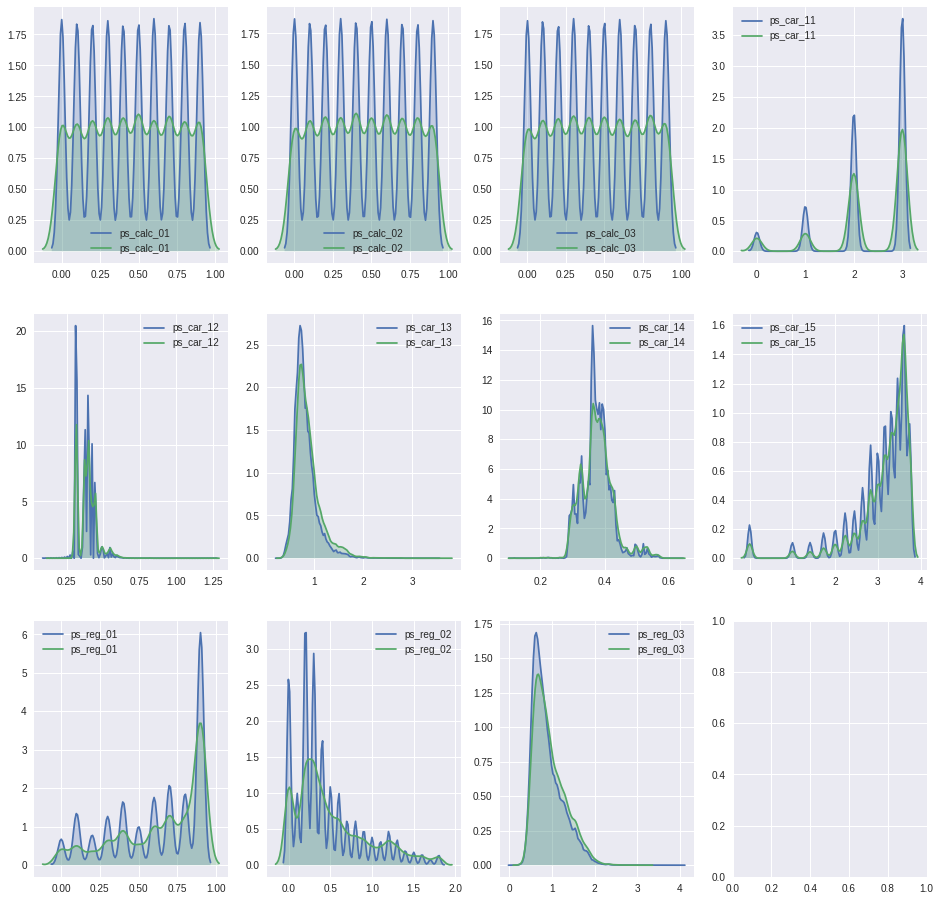

In [27]:
float_cols = [col for col in combine.columns if combine[col].dtype == 'float64']
float_cols.remove('target')
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16))

for i, col in enumerate(float_cols):
    sns.kdeplot(data = combine[combine['target'] == 0][col], ax=axs.ravel()[i], shade=True)
    sns.kdeplot(data = combine[combine['target'] == 1][col], ax=axs.ravel()[i], shade=True)


# 6 Multi-feature comparison

### 6.1 Correlation

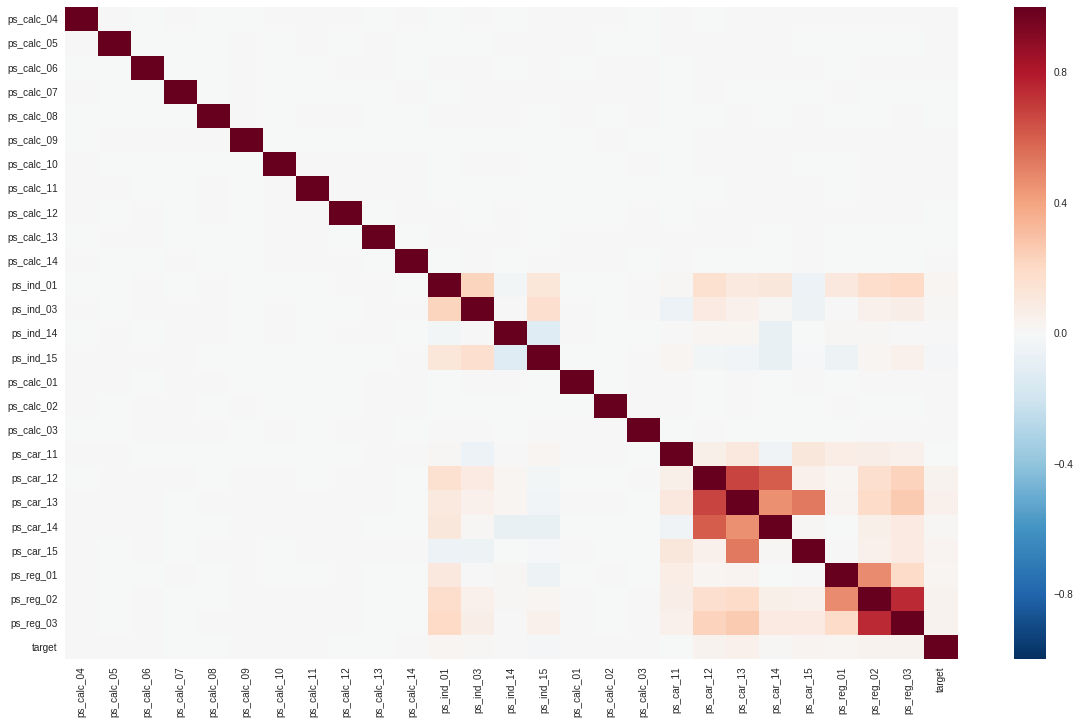

In [28]:
_ = plt.figure(figsize=(20,12))
_ = sns.heatmap(data = train[int_cols + float_cols + ['target']].corr(),annot=False)

Findings: No correlation between calculated features. No correlation between features and target. 

In [29]:
# Generate a mask for the upper triangle
corr = train[[col for col in num_cols if '_calc' not in col]].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

num_cols = int_cols + float_cols
plt.figure(figsize=(20,16))
_ = sns.heatmap(data = corr, annot=True, mask=mask)

NameError: name 'num_cols' is not defined